# ChatAnthropic

This notebook covers how to get started with Anthropic chat models.

## Setup

For setup instructions, please see the Installation and Environment Setup sections of the [Anthropic Platform page](/docs/integrations/platforms/anthropic.mdx).

In [ ]:
%pip install -qU langchain-anthropic

## Environment Setup

We'll need to get an [Anthropic](https://console.anthropic.com/settings/keys) API key and set the `ANTHROPIC_API_KEY` environment variable:

In [2]:
import os
from getpass import getpass

os.environ["ANTHROPIC_API_KEY"] = getpass()

The code provided assumes that your ANTHROPIC_API_KEY is set in your environment variables. If you would like to manually specify your API key and also choose a different model, you can use the following code:
```python
chat = ChatAnthropic(temperature=0, anthropic_api_key="YOUR_API_KEY", model_name="claude-3-opus-20240229")

```

In these demos, we will use the Claude 3 Opus model, and you can also use the launch version of the Sonnet model with `claude-3-sonnet-20240229`.

You can check the model comparison doc [here](https://docs.anthropic.com/claude/docs/models-overview#model-comparison).

In [1]:
from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate

In [5]:
chat = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")

system = (
    "You are a helpful assistant that translates {input_language} to {output_language}."
)
human = "{text}"
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])

chain = prompt | chat
chain.invoke(
    {
        "input_language": "English",
        "output_language": "Korean",
        "text": "I love Python",
    }
)

AIMessage(content='저는 파이썬을 사랑합니다.\n\nTranslation:\nI love Python.')

## `ChatAnthropic` also supports async and streaming functionality:

In [5]:
chat = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
prompt = ChatPromptTemplate.from_messages([("human", "Tell me a joke about {topic}")])
chain = prompt | chat
await chain.ainvoke({"topic": "bear"})

AIMessage(content='Sure, here\'s a joke about a bear:\n\nA bear walks into a bar and says to the bartender, "I\'ll have a pint of beer and a.......... packet of peanuts."\n\nThe bartender asks, "Why the big pause?"\n\nThe bear replies, "I don\'t know, I\'ve always had them!"')

In [6]:
chat = ChatAnthropic(temperature=0.3, model_name="claude-3-opus-20240229")
prompt = ChatPromptTemplate.from_messages(
    [("human", "Give me a list of famous tourist attractions in Japan")]
)
chain = prompt | chat
for chunk in chain.stream({}):
    print(chunk.content, end="", flush=True)

Here is a list of famous tourist attractions in Japan:

1. Tokyo Skytree (Tokyo)
2. Senso-ji Temple (Tokyo)
3. Meiji Shrine (Tokyo)
4. Tokyo DisneySea (Urayasu, Chiba)
5. Fushimi Inari Taisha (Kyoto)
6. Kinkaku-ji (Golden Pavilion) (Kyoto)
7. Kiyomizu-dera (Kyoto)
8. Nijo Castle (Kyoto)
9. Osaka Castle (Osaka)
10. Dotonbori (Osaka)
11. Hiroshima Peace Memorial Park (Hiroshima)
12. Itsukushima Shrine (Miyajima Island, Hiroshima)
13. Himeji Castle (Himeji)
14. Todai-ji Temple (Nara)
15. Nara Park (Nara)
16. Mount Fuji (Shizuoka and Yamanashi Prefectures)
17.

## Multimodal

Anthropic's Claude-3 models are compatible with both image and text inputs. You can use this as follows:


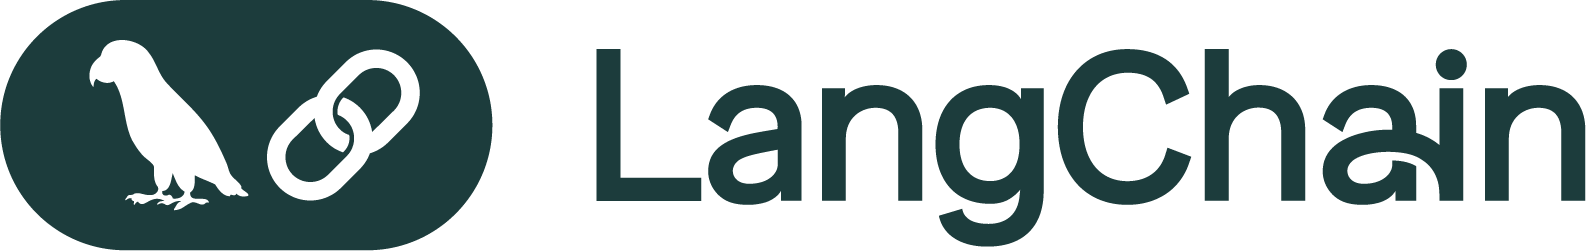

In [2]:
# open ../../../static/img/brand/wordmark.png as base64 str
import base64
from pathlib import Path

from IPython.display import HTML

img_path = Path("../../../static/img/brand/wordmark.png")
img_base64 = base64.b64encode(img_path.read_bytes()).decode("utf-8")

# display b64 image in notebook
HTML(f'<img src="data:image/png;base64,{img_base64}">')

In [6]:
from langchain_core.messages import HumanMessage

chat = ChatAnthropic(model="claude-3-opus-20240229")
messages = [
    HumanMessage(
        content=[
            {
                "type": "image_url",
                "image_url": {
                    # langchain logo
                    "url": f"data:image/png;base64,{img_base64}",  # noqa: E501
                },
            },
            {"type": "text", "text": "What is this logo for?"},
        ]
    )
]
chat.invoke(messages)

AIMessage(content='This logo is for LangChain, which appears to be some kind of software or technology platform based on the name and minimalist design style of the logo featuring a silhouette of a bird (likely an eagle or hawk) and the company name in a simple, modern font.')

## [Beta] Tool-calling

With Anthropic's [tool-calling, or tool-use, API](https://docs.anthropic.com/claude/docs/functions-external-tools), you can define tools for the model to invoke. This is extremely useful for building tool-using chains and agents, as well as for getting structured outputs from a model.

::: {.callout-note}

Anthropic's tool-calling functionality is still in beta.

:::

### bind_tools()

With `ChatAnthropic.bind_tools`, we can easily pass in Pydantic classes, dict schemas, LangChain tools, or even functions as tools to the model. Under the hood these are converted to an Anthropic tool schemas, which looks like:
```
{
    "name": "...",
    "description": "...",
    "input_schema": {...}  # JSONSchema
}
```
and passed in every model invocation.

In [4]:
from langchain_core.pydantic_v1 import BaseModel, Field

llm = ChatAnthropic(
    model="claude-3-opus-20240229",
)


class GetWeather(BaseModel):
    """Get the current weather in a given location"""

    location: str = Field(..., description="The city and state, e.g. San Francisco, CA")


llm_with_tools = llm.bind_tools([GetWeather])

In [5]:
ai_msg = llm_with_tools.invoke(
    "what is the weather like in San Francisco",
)
ai_msg

AIMessage(content=[{'text': '<thinking>\nBased on the user\'s question, the relevant function to call is GetWeather, which requires the "location" parameter.\n\nThe user has directly specified the location as "San Francisco". Since San Francisco is a well known city, I can reasonably infer they mean San Francisco, CA without needing the state specified.\n\nAll the required parameters are provided, so I can proceed with the API call.\n</thinking>', 'type': 'text'}, {'text': None, 'type': 'tool_use', 'id': 'toolu_01SCgExKzQ7eqSkMHfygvYuu', 'name': 'GetWeather', 'input': {'location': 'San Francisco, CA'}}], response_metadata={'id': 'msg_01GM3zQtoFv8jGQMW7abLnhi', 'model': 'claude-3-opus-20240229', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 487, 'output_tokens': 145}}, id='run-87b1331e-9251-4a68-acef-f0a018b639cc-0')

Notice that the output message content is a list that contains a text block and then a tool_use block:

In [7]:
ai_msg.content[0]

{'text': '<thinking>\nBased on the user\'s question, the relevant function to call is GetWeather, which requires the "location" parameter.\n\nThe user has directly specified the location as "San Francisco". Since San Francisco is a well known city, I can reasonably infer they mean San Francisco, CA without needing the state specified.\n\nAll the required parameters are provided, so I can proceed with the API call.\n</thinking>',
 'type': 'text'}

In [8]:
ai_msg.content[1]

{'text': None,
 'type': 'tool_use',
 'id': 'toolu_01SCgExKzQ7eqSkMHfygvYuu',
 'name': 'GetWeather',
 'input': {'location': 'San Francisco, CA'}}

::: {.callout-tip}

ChatAnthropic model outputs are always a single AI message that can have either a single string or a list of content blocks. The content blocks can be text blocks or tool-duse blocks. There can be multiple of each and they can be interspersed.

:::

### Parsing tool calls

The `langchain_anthropic.output_parsers.ToolsOutputParser` makes it easy to extract just the tool calls from an Anthropic AI message:

In [9]:
from langchain_anthropic.output_parsers import ToolsOutputParser

parser = ToolsOutputParser()
chain = llm_with_tools | parser
chain.invoke("What is the weather like in nyc, la, sf and cleveland")

[{'name': 'GetWeather',
  'args': {'location': 'New York City, NY'},
  'id': 'toolu_01UK2AEWa75PUGA3DpiaHfBN',
  'index': 1},
 {'name': 'GetWeather',
  'args': {'location': 'Los Angeles, CA'},
  'id': 'toolu_01M84DY7xWg9bLoX6JCArczx',
  'index': 2},
 {'name': 'GetWeather',
  'args': {'location': 'San Francisco, CA'},
  'id': 'toolu_01FEasmxGpxFPwf9SF3nCTeb',
  'index': 3},
 {'name': 'GetWeather',
  'args': {'location': 'Cleveland, OH'},
  'id': 'toolu_01B8fZdiyPbzWyj5cDCzGSTe',
  'index': 4}]

The `index` tells us where in the original list of content blocks each tool call was.

We can pass in Pydantic classes to parse our tool calls into pydantic objects:

In [16]:
parser = ToolsOutputParser(pydantic_schemas=[GetWeather])
chain = llm_with_tools | parser
chain.invoke("What is the weather like in nyc, la, sf and cleveland")

[GetWeather(location='New York City, NY'),
 GetWeather(location='Los Angeles, CA'),
 GetWeather(location='San Francisco, CA'),
 GetWeather(location='Cleveland, OH')]

If we want we can return only the first tool call:

In [11]:
parser = ToolsOutputParser(first_tool_only=True)
chain = llm_with_tools | parser
chain.invoke("What is the weather like in nyc")

{'name': 'GetWeather',
 'args': {'location': 'New York City, NY'},
 'id': 'toolu_01EjFAADbpdrML1uaSMr9tN3',
 'index': 1}

### with_structured_output()

The [BaseChatModel.with_structured_output interface](/docs/modules/model_io/chat/structured_output) makes it easy to get structured output from chat models. You can use `ChatAnthropic.with_structured_output`, which uses tool-calling under the hood), to get the model to more reliably return an output in a specific format:

In [18]:
structured_llm = llm.with_structured_output(GetWeather)
structured_llm.invoke(
    "what is the weather like in San Francisco",
)

GetWeather(location='San Francisco, CA')

### Passing tool results to model

We can use `ToolMessage`s with the appropriate `tool_call_id`s to pass tool results back to the model:

In [5]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

messages = [
    HumanMessage("What is the weather like in San Francisco"),
    AIMessage(
        content=[
            {
                "text": '<thinking>\nBased on the user\'s question, the relevant function to call is GetWeather, which requires the "location" parameter.\n\nThe user has directly specified the location as "San Francisco". Since San Francisco is a well known city, I can reasonably infer they mean San Francisco, CA without needing the state specified.\n\nAll the required parameters are provided, so I can proceed with the API call.\n</thinking>',
                "type": "text",
            },
            {
                "type": "tool_use",
                "id": "toolu_01SCgExKzQ7eqSkMHfygvYuu",
                "name": "GetWeather",
                "input": {"location": "San Francisco, CA"},
                "text": None,
            },
        ],
    ),
    ToolMessage(
        "Rain. High 54F. Winds SW at 15 to 25 mph. Chance of rain 100%.",
        tool_call_id="toolu_01SCgExKzQ7eqSkMHfygvYuu",
    ),
]
llm_with_tools.invoke(messages)

AIMessage(content='Based on calling the GetWeather function, the weather in San Francisco, CA is:\nRain with a high temperature of 54°F and winds from the southwest at 15-25 mph. There is a 100% chance of rain.', response_metadata={'id': 'msg_01J7nWVRPPTgae4eDpf9yR3M', 'model': 'claude-3-opus-20240229', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 670, 'output_tokens': 56}}, id='run-44fcd34f-9c24-464f-94dd-63bd0d22870d-0')

### Streaming

::: {.callout-warning}

Anthropic does not currently support streaming tool calls. Attempting to stream will yield a single final message.

:::

In [8]:
list(llm_with_tools.stream("What's the weather in san francisco"))

/Users/bagatur/langchain/libs/partners/anthropic/langchain_anthropic/chat_models.py:328: UserWarning: stream: Tool use is not yet supported in streaming mode.
  warnings.warn("stream: Tool use is not yet supported in streaming mode.")


[AIMessage(content=[{'text': '<thinking>\nThe user is asking for the current weather in a specific location, San Francisco. The GetWeather function is the relevant tool to answer this request, as it returns the current weather for a given location.\n\nThe GetWeather function has one required parameter:\nlocation: The city and state, e.g. San Francisco, CA\n\nThe user provided the city San Francisco in their request. They did not specify the state, but it can be reasonably inferred that they are referring to San Francisco, California since that is the most well known city with that name.\n\nSince the required location parameter has been provided by the user, we can proceed with calling the GetWeather function.\n</thinking>', 'type': 'text'}, {'text': None, 'type': 'tool_use', 'id': 'toolu_01V9ZripoQzuY8HubspJy6fP', 'name': 'GetWeather', 'input': {'location': 'San Francisco, CA'}}], id='run-b825206b-5b6b-48bc-ad8d-802dee310c7f')]